In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import seaborn as sn
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

#print(check_output(["ls", "../input"]).decode("utf8"))

%matplotlib inline
# Any results you write to the current directory are saved as output.

**Load Dataset**

In [2]:
#BikeData = pd.read_csv("../input/train.csv")
BikeData = pd.read_csv("./train.csv")

**Exploratory Data Analysis**

In [3]:
BikeData.shape

(10886, 12)

**Data Types of the Variables**

In [4]:
BikeData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Extacts the time features from the datetime for more robust analysis

In [5]:
#Convert BikeData.datetime to datetime
BikeData.datetime = pd.to_datetime(BikeData.datetime)
#Extract Month
BikeData['month'] = BikeData.datetime.dt.month
#Extract Hour
BikeData['hour'] = BikeData.datetime.dt.hour

### Defines the categorical variables as categorical variables and then displays the datatypes to confirm the data definitions

In [6]:
categoryVariableList = ["hour","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    BikeData[var] = BikeData[var].astype("category")
BikeData.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
month               category
hour                category
dtype: object

# Plots of Weather Condition, Season, Month, and Day Type by User Type by Time

In [7]:
#Defines Dictionaries to Help Convert our data into Human Readable Labels
WeatherTypes = {
                1: 'No Precipitation',
                2: 'Light Precipitation',
                3: 'Medium Precipitation',
                4: 'Heavy Precipitation'
            }

Season = {
 1: 'Winter',
 2: 'Spring', 
 3: 'Summer', 
 4: 'Fall', 
}

WorkingDay = {
    0:'Non-Business Day',
    1:'Business Day'  
}

#Builds Help Functions for Plotting our data
def transform_data(TempBikeData,UserType="All"):
    #Makes a copy of the Dataframe so that our deletes don't happen on the underlying dataframe
    TempBikeData = TempBikeData.copy()
    #If the UserType is Casual then our analysis will be only on the Casual Users
    if UserType == 'Casual':
        TempBikeData.loc[:,'count'] = TempBikeData['casual']
    #If the UserType is Registered then we only look at the Registered Users
    elif UserType == 'Registered':
        TempBikeData.loc[:,'count'] = TempBikeData['registered']
    #Delete unnecassary variables
    del TempBikeData['casual']
    del TempBikeData['registered']
    
    #Find Average number of riders by month
    MonthAggregated = pd.DataFrame(TempBikeData.groupby("month")["count"].mean()).reset_index()
    #Label the Month in the MMM format
    MonthAggregated.month = MonthAggregated.month.apply(lambda x: calendar.month_abbr[x])
    
    #Find average number of riders by Season
    SeasonAggregated = pd.DataFrame(TempBikeData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
    #Label the Season. Note the label's here: https://www.kaggle.com/c/bike-sharing-demand/data are incorrect.
    SeasonAggregated.season = SeasonAggregated.season.apply(lambda x: Season[x])
    
    #Find the average number of riders for workingdays vs. non-working days
    WorkDayAggregated = pd.DataFrame(TempBikeData.groupby(["hour","workingday"],sort=True)["count"].mean()).reset_index()
    #Label's the binary variable as text
    WorkDayAggregated.workingday = WorkDayAggregated.workingday.apply(lambda x: WorkingDay[x])
    
    #Find the average number of riders by weather
    WeatherAggregated = pd.DataFrame(TempBikeData.groupby(["hour","weather"],sort=True)["count"].mean()).reset_index()
    #Converts this into a more readable format
    WeatherAggregated.weather = WeatherAggregated.weather.apply(lambda x: WeatherTypes[x])

    return MonthAggregated, SeasonAggregated, WorkDayAggregated, WeatherAggregated
    
def data_plots(i,user_type,MonthAggregated,SeasonAggregated,WorkDayAggregated,WeatherAggregated):
    #Defines the subplot, we will be plotting to
    ax = plt.subplot(3,4, i*4+1)
    #Plots the Month Data and Labels it
    _ =sn.barplot(data=MonthAggregated,x="month",y="count",ax=ax)
    _ = ax.set(xlabel='Month', ylabel='Average User Count')
    ax.set_title("Average {} User Count By Month".format(user_type),fontsize=20)
    
    #Plots the Season Data
    ax = plt.subplot(3,4, i*4+2)
    _ = sn.pointplot(x=SeasonAggregated["hour"], y=SeasonAggregated["count"],hue=SeasonAggregated["season"], 
                     data=SeasonAggregated, join=True,ax=ax)
    _ = ax.set(xlabel='Hour Of The Day', ylabel='Users Count',label='big')
    ax.set_title("Average {} User Count by Hour by Season".format(user_type),fontsize=20)
    
    #Plots the Work Day Data
    ax = plt.subplot(3,4, i*4+3)
    _ = sn.pointplot(x=WorkDayAggregated["hour"], y=WorkDayAggregated["count"],
                     hue=WorkDayAggregated["workingday"], data=hourAggregated, join=True,ax=ax)
    _ = ax.set(xlabel='Hour Of The Day', ylabel='Users Count',label='big')
    ax.set_title("Average {} User Count by Hour for \n Workdays vs. Non Work Days".format(user_type),fontsize=20)
    
    #Plots the Weather Data
    ax = plt.subplot(3,4, i*4+4)
    _ = sn.pointplot(x=WeatherAggregated["hour"], y=WeatherAggregated["count"],
                     hue=WeatherAggregated["weather"], data=WeatherAggregated, join=True,ax=ax)
    _ = ax.set(xlabel='Hour Of The Day', ylabel='Users Count',label='big')
    ax.set_title("Average {} User Count by Hour by Weather".format(user_type),fontsize=20)
 

## Basic EDA by Month, Workday, Season, and Weather
=====================================================================

As we can see based on the plots below there are significant differences in the behavior of casual users compared with the behaviour of registered users. Given these differences, it makes sense to build two generative models, one for causal users and one for registered users. Once we have built these predictions we can then add these two outputs together to help determine our total count.

NameError: global name 'calendar' is not defined

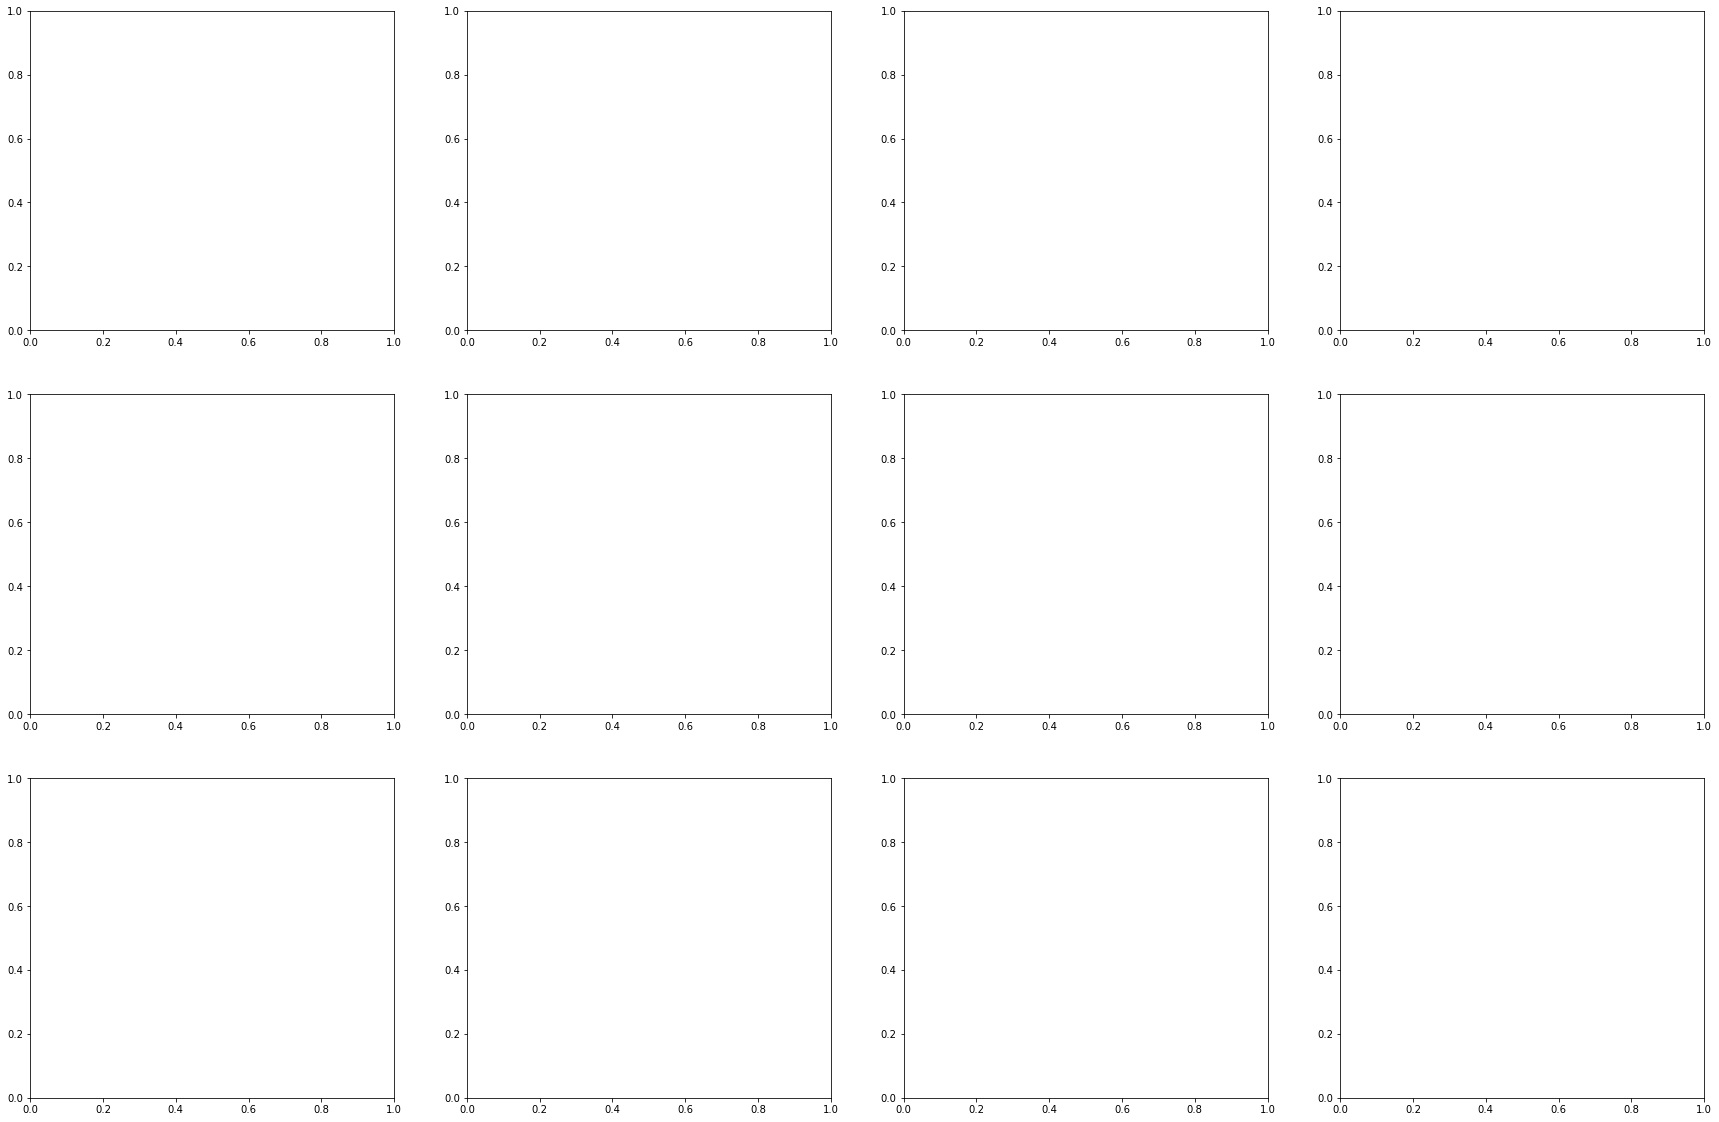

In [8]:
UserTypes = ['Total','Casual','Registered']
ax, fig = plt.subplots(3,4,figsize=(30,20))

for i,UType in enumerate(UserTypes):
    #Calls the functions defined above to plot the basic data
    MonthAggregated, SeasonAggregated, WorkDayAggregated, WeatherAggregated = transform_data(BikeData,UType)
    data_plots(i,UType,MonthAggregated,SeasonAggregated,WorkDayAggregated,WeatherAggregated)
plt.tight_layout()

Additionally from the plots, we can see that Heavy Precipitation is very rare. Let's do some further analysis to access how many of occurences there are in our dataset.

In [202]:
BikeData[BikeData.weather==4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,1,18


In fact after exploring further we can see that there is only one occurance where weather is equal to 4 ("Heavy Precipitation") in our dataset. Given one occurance is not particularly useful for building a predictive model, we must decided what to do with "Heavy Precipitation" occurences. We could either exclude this datapoint from our predictive model or we could combine it with the "Medium Precipitation" variable. We will take the approach of combining the "Medium Precipitation" and "Heavy Precipitation" into one variable which we will call "Heavy Precipitation", but are mindfull this may over predict riders in situations where there is "Heavy Precipitation".

In [208]:
def transform_weather(BikeData):
    #Converts occurences of weather = 4 to weather = 3
    BikeData.weather = BikeData.weather.apply(lambda x: x if x != 4 else 3)
    return BikeData

BikeData = transform_weather(BikeData)

In [218]:
#Transforms the Dataframes
def break_out_users(BikeData):
    Casual = BikeData.copy()
    Registered = BikeData.copy()

    del Casual['count']
    del Casual['registered']

    del Registered['count']
    del Registered['casual']

    Casual.rename(columns={'casual': 'count'}, inplace=True)
    Registered.rename(columns={'registered': 'count'}, inplace=True)
    return Casual, Registered

Casual, Registered = break_out_users(BikeData)

In [223]:
#Still working on this

#ax, fig = plt.subplots(3,4,figsize=(30,20))

#Plots the Work Day Data
#ax = plt.subplot(3,4, i*4+3)
#_ = sn.pointplot(x=WorkDayAggregated["hour"], y=WorkDayAggregated["count"],
#                 hue=WorkDayAggregated["workingday"], data=hourAggregated, join=True,ax=ax)
#_ = ax.set(xlabel='Hour Of The Day', ylabel='Users Count',label='big')
#ax.set_title("Average {} User Count by Hour for \n Workdays vs. Non Work Days".format(user_type),fontsize=20)


# Create scatterplot of dataframe
#sn.lmplot('temp', # Horizontal axis
#           'count', # Vertical axis
#           data=Casual, # Data source
#           fit_reg=False # Don't fix a regression line
#          )
#Casual

In [221]:
sn.lmplot?